# Representation Learning

## Packages and Presets

In [48]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import Tensor

import yaml
import math
from tqdm import tqdm, trange
import os

import matplotlib.pyplot as plt
import seaborn as sns   

import copy
from tqdm import tqdm

from sklearn.metrics import (
    f1_score, 
    balanced_accuracy_score, 
    confusion_matrix,
    ConfusionMatrixDisplay, 
    accuracy_score,
    classification_report,
    precision_score,
    recall_score,
)
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

from torch.utils.tensorboard import SummaryWriter
from imblearn.over_sampling import SMOTE

# normalize embeddings:
from sklearn.preprocessing import StandardScaler

from info_nce import InfoNCE

from lightgbm import LGBMClassifier


from representation_learning_utils import (
    MITBIH_Dataset,
    MITBIH_Augment_Dataset,
    PTB_Dataset,
    EarlyStopping,
    set_all_seeds,
    train_and_validate_encoder
)


pd.set_option('display.max_columns', None)

In [51]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

with open("representation_learning_config.yaml", "r") as file:
    config = yaml.safe_load(file)

## Data Loading and Preprocessing

In [99]:
# Load data
mitbih_train_df = pd.read_csv(config["paths"]["mitbih_train"], header=None)
mitbih_test_df = pd.read_csv(config["paths"]["mitbih_test"], header=None)

In [100]:
print(f"{mitbih_train_df.shape=}")
print(f"{mitbih_test_df.shape=}")

mitbih_train_df.shape=(87554, 188)
mitbih_test_df.shape=(21892, 188)


In [101]:
# relative frequency of each label class in %
mitbih_train_df.iloc[:, -1].value_counts(normalize = True) * 100

187
0.0    82.772917
4.0     7.345181
2.0     6.610777
1.0     2.539005
3.0     0.732120
Name: proportion, dtype: float64

As we can see the train set is very imbalanced. As a consequence, we will once again make use of SMOTE oversampling.

In [102]:
mitbih_X_train_full = mitbih_train_df.iloc[:, :-1].to_numpy()
mitbih_y_train_full = mitbih_train_df.iloc[:, -1].to_numpy()

mitbih_X_test = mitbih_test_df.iloc[:, :-1].to_numpy()
mitbih_y_test = mitbih_test_df.iloc[:, -1].to_numpy()

As mentioned above, we will oversample the minority classes using SMOTE.

In [104]:
sm = SMOTE(random_state=config["general"]["seed"])
mitbih_X_train_full_resampled, mitbih_y_train_full_resampled = sm.fit_resample(mitbih_X_train_full, mitbih_y_train_full)
print(f"{mitbih_X_train_full_resampled.shape=}")
print(f"{np.unique(mitbih_y_train_full_resampled, return_counts=True)=}")

mitbih_X_train_full_resampled.shape=(362355, 187)
np.unique(mitbih_y_train_full_resampled, return_counts=True)=(array([0., 1., 2., 3., 4.]), array([72471, 72471, 72471, 72471, 72471]))


In [105]:
mitbih_train_loader = DataLoader(
        MITBIH_Dataset(mitbih_X_train_full_resampled, mitbih_y_train_full_resampled),
        batch_size=config["dataloader"]["train_batch_size"],
        shuffle=True,
        pin_memory=True,
        num_workers=0,
)


mitbih_test_loader = DataLoader(
    MITBIH_Dataset(mitbih_X_test, mitbih_y_test),
    batch_size=config["dataloader"]["test_batch_size"],
    shuffle=False,
    pin_memory=True,
    num_workers=0,
)

Split into train and validation sets:

In [9]:
mitbih_X_train, mitbih_X_val, mitbih_y_train, mitbih_y_val = train_test_split(
    mitbih_X_train_full,
    mitbih_y_train_full,
    test_size=0.1, 
    stratify=mitbih_y_train_full, 
    random_state=config["general"]["seed"]
)

As mentioned above, we will oversample the minority classes using SMOTE.

In [ ]:
sm = SMOTE(random_state=config["general"]["seed"])
mitbih_X_train_resampled, mitbih_y_train_resampled = sm.fit_resample(mitbih_X_train, mitbih_y_train)
print(f"{mitbih_X_train_resampled.shape=}")
print(f"{np.unique(mitbih_y_train_resampled, return_counts=True)=}")

In [ ]:
mitbih_train_loader_augmented = DataLoader(
    MITBIH_Augment_Dataset(mitbih_X_train),
    batch_size=config["dataloader"]["augmented_train_batch_size"],
    shuffle=True,
    pin_memory=True,
    num_workers=0,
)

mitbih_val_loader_augmented = DataLoader(
    MITBIH_Augment_Dataset(mitbih_X_val),
    batch_size=config["dataloader"]["augmented_val_batch_size"],
    shuffle=False,
    pin_memory=True,
    num_workers=0,
)

Let's plot some augmented examples:

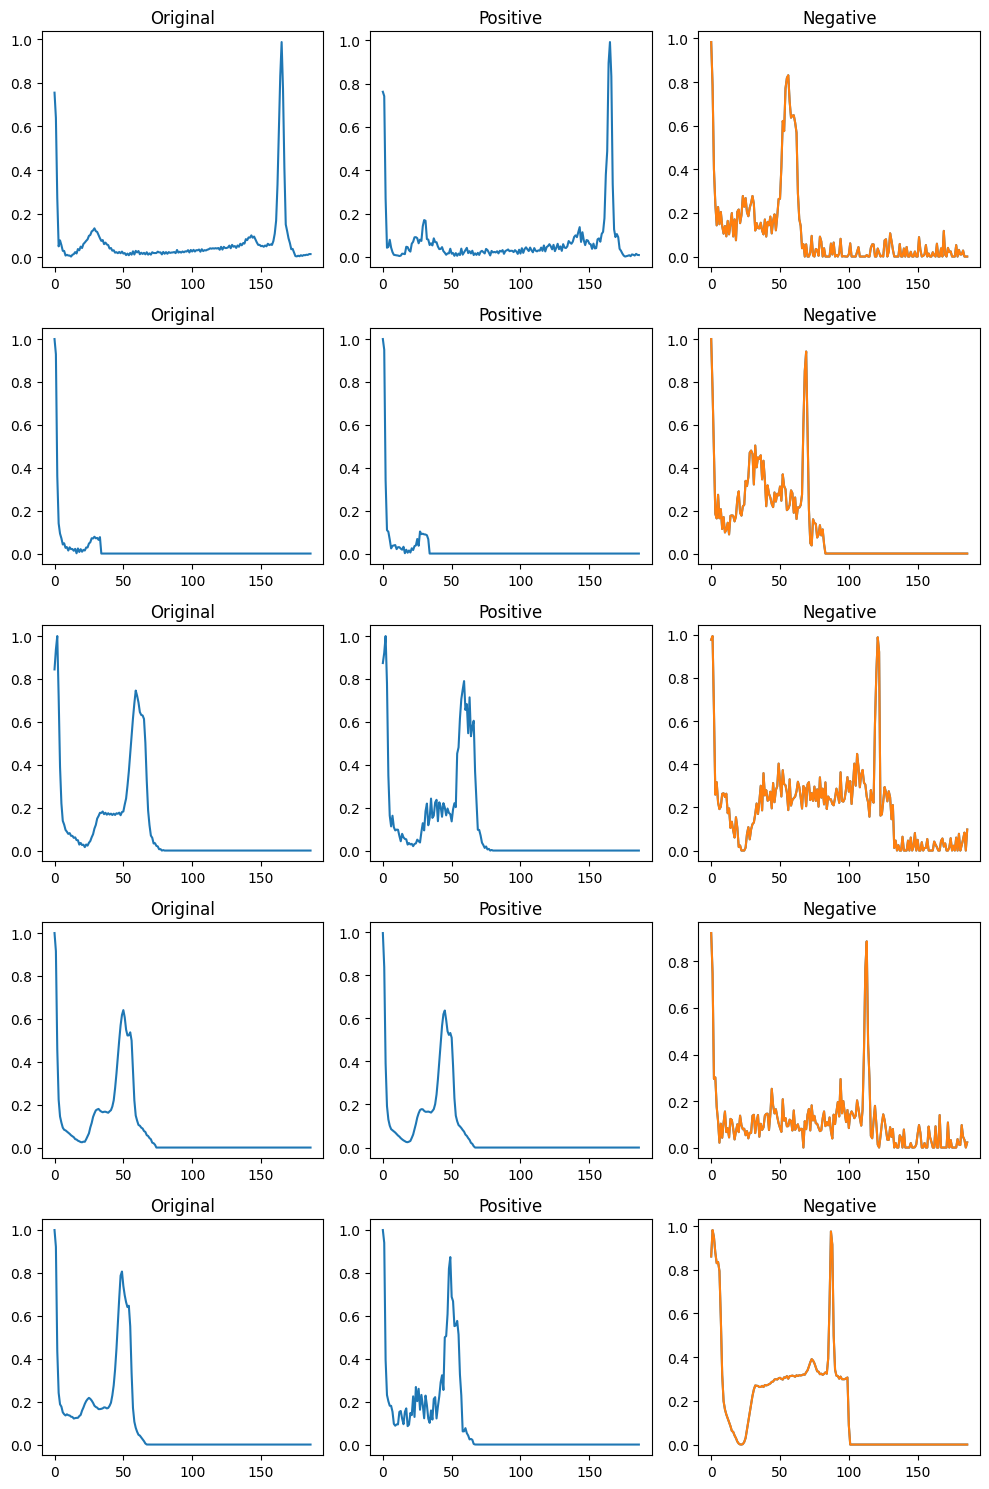

In [11]:
# plot some examples from the augmented train dataloader:
examples = next(iter(mitbih_train_loader_augmented))

samples = examples[0]
pos = examples[1]
neg = examples[2]


fig, axs = plt.subplots(5, 3, figsize=(10, 15))

for i in range(5):
    axs[i, 0].plot(samples[i].numpy())
    axs[i, 0].set_title(f"Original")
    axs[i, 1].plot(pos[i].numpy())
    axs[i, 1].set_title(f"Positive")
    axs[i, 2].plot(neg[i][0].numpy())
    axs[i, 2].set_title(f"Negative")
    axs[i, 2].plot(neg[i][0].numpy())

fig.tight_layout()

## Model Definition

Note that in the following CNN we do not normalize the resulting embeddings, since this will be done in a later step and is already implemented in the `InfoNCE` loss by default.

In [12]:
# We based our CNN on this: https://medium.com/@chen-yu/building-a-customized-residual-cnn-with-pytorch-471810e894ed
class CNNEncoder(nn.Module):
    def __init__(self, latent_dim: int, in_channels: int):
        super().__init__()

        self.conv1 = self._create_conv_block(in_channels, 32, 3, 1)
        self.conv2 = self._create_conv_block(32, 64, 3, 1)
        self.conv3 = self._create_conv_block(64, 128, 3, 1)
        self.adaptive_pool = nn.AdaptiveAvgPool1d(output_size = 10)
        
        
        # Flattening and final linear layer
        self.flatten = nn.Flatten(1)
        self.fc = nn.Linear(1280, latent_dim)

    def forward(self, x: Tensor) -> Tensor:
        x = x.unsqueeze(1) # Add channel dimension
        # now: [batch_size, in_channels, seq_len] i.e. [batch_size, 1, 187]
        
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.adaptive_pool(x)
        
        x = self.flatten(x)
        x = self.fc(x)
        return x
    
    def _create_conv_block(self, in_channels: int, out_channels: int, kernel_size: int, stride: int):
        return nn.Sequential(
            nn.Conv1d(
                in_channels=in_channels, 
                out_channels=out_channels, 
                kernel_size=kernel_size, 
                stride=stride, 
                padding=1, 
                bias=False
            ),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )


set_all_seeds(config["general"]["seed"])
encoder=CNNEncoder(latent_dim=config["contrastive_model"]["latent_dim"], in_channels=1).to(DEVICE)

We use a model that resembles the CDCK* speaker models used in the paper `Representation Learning with Contrastive Predictive Coding`. The class below was inspired by this
[GitHub repository](https://github.com/jefflai108/Contrastive-Predictive-Coding-PyTorch/blob/master/src/model/model.py).

In [13]:
class ContrastiveNet(nn.Module):
    def __init__(self, encoder: nn.Module, latent_dim: int, project_dim: int):
        super().__init__()
        self.encoder = encoder
        self.projection_head = nn.Sequential(
            nn.Linear(latent_dim, latent_dim),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(latent_dim, project_dim)
        )
    def forward(self, x: Tensor) -> Tensor:
        x = self.encoder(x)
        x = self.projection_head(x)
        return x

## Training

In [14]:
optimizer = optim.AdamW(
        encoder.parameters(),
        lr=config["adamw"]["learning_rate"],
        weight_decay=config["adamw"]["weight_decay"],
)
criterion = InfoNCE(negative_mode="paired")
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=config["scheduler"]["factor"],
    patience=config["scheduler"]["patience"],
)

early_stopping = EarlyStopping(
    start=config["early_stopping"]["start"],
    patience=config["early_stopping"]["patience"],
    verbose=True,
    mode="min",
)
summary_writer = SummaryWriter(log_dir=config["paths"]["summary_writer"])

In [15]:
contrastive_model = ContrastiveNet(
    encoder=encoder,
    latent_dim=config["contrastive_model"]["latent_dim"], 
    project_dim=config["contrastive_model"]["projection_dim"]
).to(DEVICE)

In [16]:
contrastive_model = train_and_validate_encoder(
    model=contrastive_model,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    train_augment_loader=mitbih_train_loader_augmented,
    val_augment_loader=mitbih_val_loader_augmented,
    best_model_path= "../weights/repr.pth", #config["paths"]["contrastive_model"],
    device=DEVICE,
    num_epochs=config["contrastive_model"]["num_epochs"],
    ES=early_stopping,
    summary_writer=summary_writer,
)

Training ContrastiveNet:  30%|██▉       | 59/200 [57:28<2:17:21, 58.45s/it, train_loss=6.49e-5, val_loss=4.2e-5]  

Early stopping at epoch 59. Best score was 0.0000 in epoch 49.


In [52]:
torch.save(contrastive_model.encoder.state_dict(), config["paths"]["encoder"])

In [53]:
encoder2 = CNNEncoder(latent_dim=config["contrastive_model"]["latent_dim"], in_channels=1).to(DEVICE)
encoder2.load_state_dict(torch.load(config["paths"]["encoder"]))

<All keys matched successfully>

## Extracting Embeddings

In [106]:
mitbih_train_embeddings = []
mitbih_y_train = []

contrastive_model.eval()


for seq, y in tqdm(mitbih_train_loader):
    seq = seq.to(DEVICE)
    with torch.no_grad():
        output = contrastive_model.encoder(seq).cpu().numpy()
        mitbih_train_embeddings.append(output)
        mitbih_y_train.append(y)

mitbih_train_embeddings = np.vstack(mitbih_train_embeddings)
mitbih_y_train = np.concatenate(mitbih_y_train)

100%|██████████| 5662/5662 [00:02<00:00, 1976.90it/s]


In [107]:
mitbih_test_embeddings = []
mitbih_y_test = []


contrastive_model.eval()

for seq, y in tqdm(mitbih_test_loader):
    seq =seq.to(DEVICE)
    with torch.no_grad():
        output = contrastive_model.encoder(seq).cpu().numpy()
        mitbih_test_embeddings.append(output)
        mitbih_y_test.append(y)
    
mitbih_test_embeddings = np.vstack(mitbih_test_embeddings)
mitbih_y_test = np.concatenate(mitbih_y_test)

100%|██████████| 86/86 [00:00<00:00, 803.32it/s]


In [108]:
# save train and test embeddings, y_train, y_test to numpy:
np.save("embeddings/mitbih_train_embeddings.npy", mitbih_train_embeddings)
np.save("embeddings/mitbih_test_embeddings.npy", mitbih_test_embeddings)
np.save("embeddings/mitbih_y_train.npy", mitbih_y_train)
np.save("embeddings/mitbih_y_test.npy", mitbih_y_test)

## Performance Evaluation on Downstream Tasks

### MIT BIH

In [109]:
# standardize embeddings
scaler = StandardScaler()
mitbih_train_embeddings_scaled = scaler.fit_transform(mitbih_train_embeddings)
mitbih_test_embeddings_scaled = scaler.transform(mitbih_test_embeddings)


In [110]:
boost = LGBMClassifier(
    n_estimators= 1000,
    random_state=config["general"]["seed"],
    n_jobs=-1,
    verbose = -1
)

In [111]:
boost.fit(mitbih_train_embeddings_scaled, mitbih_y_train)

In [ ]:
y_preds = boost.predict(mitbih_test_embeddings_scaled)

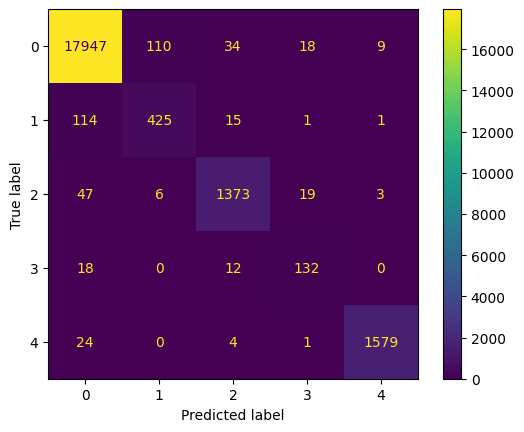

In [ ]:
cm = confusion_matrix(mitbih_y_test, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3, 4])
disp.plot()

In [ ]:
print(f"Test accuracy: {accuracy_score(mitbih_y_test, y_preds):.6f}")
print(f"Test balanced accuracy: {balanced_accuracy_score(mitbih_y_test, y_preds):.6f}")
print(f"Test f1 score: {f1_score(mitbih_y_test, y_preds, average = 'macro'):.6f}")
print(f"Test precision: {precision_score(mitbih_y_test, y_preds, average = 'macro'):.6f}")
print(f"Test recall: {recall_score(mitbih_y_test, y_preds, average = 'macro'):.6f}")

Test accuracy: 0.980084
Test balanced accuracy: 0.899987
Test f1 score: 0.899137
Test precision: 0.898592
Test recall: 0.899987


In [ ]:
print(classification_report(mitbih_y_test, y_preds))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     18118
           1       0.79      0.76      0.77       556
           2       0.95      0.95      0.95      1448
           3       0.77      0.81      0.79       162
           4       0.99      0.98      0.99      1608

    accuracy                           0.98     21892
   macro avg       0.90      0.90      0.90     21892
weighted avg       0.98      0.98      0.98     21892



## PTB Dataset

The same can also be done for the PTB dataset, just to show that the embeddings are indeed useful for other tasks as well.

In [71]:
# Load data:
ptb_train_df = pd.read_csv(config["paths"]["ptb_train"], header=None)
ptb_test_df = pd.read_csv(config["paths"]["ptb_test"], header=None)

# separate features and labels:
ptb_X_train = ptb_train_df.iloc[:, :-1].to_numpy()
ptb_y_train = ptb_train_df.iloc[:, -1].to_numpy()

# 0-pad sequences to uniform, 190, length:
ptb_X_test = ptb_test_df.iloc[:, :-1].to_numpy()
ptb_y_test = ptb_test_df.iloc[:, -1].to_numpy()

In [72]:
sm = SMOTE(random_state=config["general"]["seed"])
ptb_X_train, ptb_y_train = sm.fit_resample(ptb_X_train, ptb_y_train)
print(ptb_X_train.shape, ptb_y_train.shape)
print(np.unique(ptb_y_train, return_counts=True))

(16808, 187) (16808,)
(array([0., 1.]), array([8404, 8404]))


In [73]:
ptb_train_loader = DataLoader(
    PTB_Dataset(ptb_X_train, ptb_y_train),
    batch_size=32,
    shuffle=True,
    pin_memory=True,
    num_workers=0,
)
ptb_test_loader = DataLoader(
    PTB_Dataset(ptb_X_test, ptb_y_test),
    batch_size=256,
    shuffle=False,
    pin_memory=True,
    num_workers=0,
)

In [74]:
ptb_train_embeddings = []
ptb_y_train = []


contrastive_model.eval()

for seq, y in tqdm(ptb_train_loader):
    seq = seq.to(DEVICE)
    with torch.no_grad():
        output = contrastive_model.encoder(seq).cpu().numpy()
        ptb_train_embeddings.append(output)
        ptb_y_train.append(y)

ptb_train_embeddings = np.vstack(ptb_train_embeddings)
ptb_y_train = np.concatenate(ptb_y_train)

100%|██████████| 526/526 [00:00<00:00, 2059.49it/s]


In [75]:
ptb_test_embeddings = []
ptb_y_test = []


contrastive_model.eval()

for seq, y in tqdm(ptb_test_loader):
    seq = seq.to(DEVICE)
    with torch.no_grad():
        output = contrastive_model.encoder(seq).cpu().numpy()
        ptb_test_embeddings.append(output)
        ptb_y_test.append(y)

ptb_test_embeddings = np.vstack(ptb_test_embeddings)
ptb_y_test = np.concatenate(ptb_y_test)

100%|██████████| 12/12 [00:00<00:00, 647.16it/s]


In [76]:
np.save("embeddings/ptb_train_embeddings.npy", ptb_train_embeddings)
np.save("embeddings/ptb_test_embeddings.npy", ptb_test_embeddings)
np.save("embeddings/ptb_y_train.npy", ptb_y_train)
np.save("embeddings/ptb_y_test.npy", ptb_y_test)

In [77]:
# standardize embeddings
scaler = StandardScaler()
ptb_train_embeddings_scaled = scaler.fit_transform(ptb_train_embeddings)
ptb_test_embeddings_scaled = scaler.transform(ptb_test_embeddings)

In [78]:
boost = LGBMClassifier(
    n_estimators= 1000,
    random_state=config["general"]["seed"],
    n_jobs=-1,
    verbose = -1
)

In [82]:
boost.fit(ptb_train_embeddings_scaled, ptb_y_train)

LGBMClassifier(n_estimators=1000, n_jobs=-1, random_state=42, verbose=-1)

In [83]:
y_preds = boost.predict(ptb_test_embeddings_scaled)

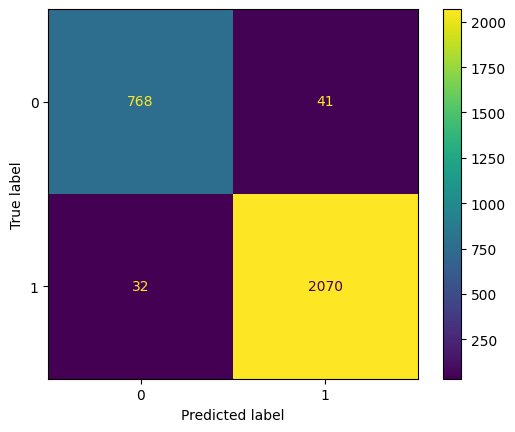

In [84]:
cm = confusion_matrix(ptb_y_test, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()

In [85]:
print(f"Test accuracy: {accuracy_score(ptb_y_test, y_preds):.6f}")
print(f"Test balanced accuracy: {balanced_accuracy_score(ptb_y_test, y_preds):.6f}")
print(f"Test f1 score: {f1_score(ptb_y_test, y_preds):.6f}")
print(f"Test precision: {precision_score(ptb_y_test, y_preds):.6f}")
print(f"Test recall: {recall_score(ptb_y_test, y_preds):.6f}")

Test accuracy: 0.974923
Test balanced accuracy: 0.967048
Test f1 score: 0.982673
Test precision: 0.980578
Test recall: 0.984776


In [86]:
print(classification_report(ptb_y_test, y_preds))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95       809
           1       0.98      0.98      0.98      2102

    accuracy                           0.97      2911
   macro avg       0.97      0.97      0.97      2911
weighted avg       0.97      0.97      0.97      2911

